<a href="https://colab.research.google.com/github/KornelWitkowski/TensorFlow-benchmarks/blob/main/notebooks/Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification

## Fashion MNIST

### Data preparation 

In [ ]:
import os
import tensorflow as tf

from tensorflow.keras import datasets

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

len(train_images), len(test_images)

4431872/4422102 [==============================] - 0s 0us/step


(60000, 10000)

In [ ]:
class_names = {0: "T-shirt/top",
               1: "Trouser",
               2: "Pullover",
               3: "Dress",
               4: "Coat",
               5: "Sandal",
               6: "Shirt",
               7: "Sneaker",
               8: "Bag",
               9: "Ankle boot"}

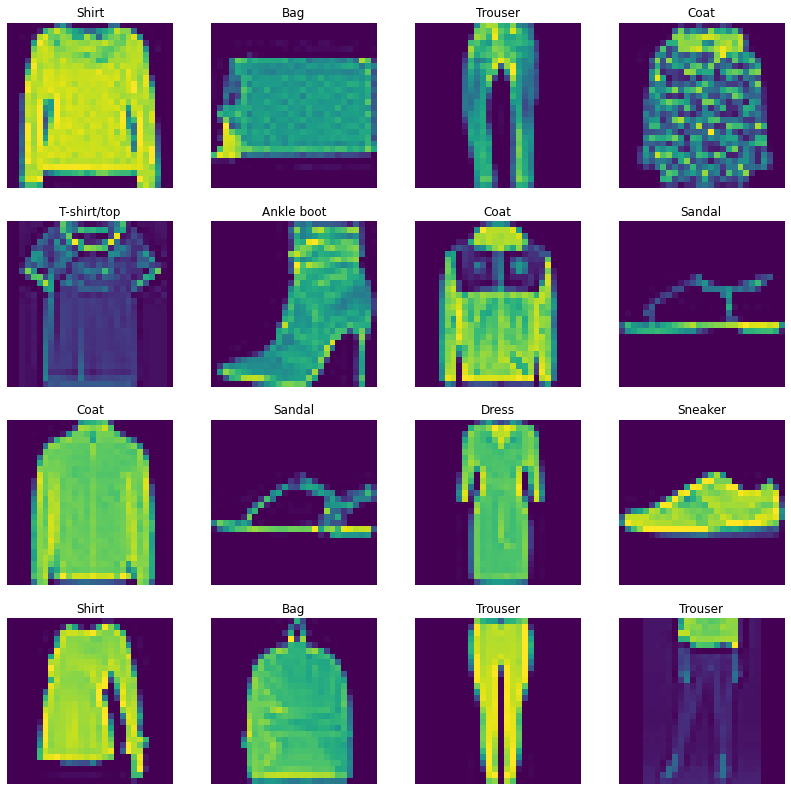

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4,4, figsize=(14,14))

for i in range(16):
    j = np.random.randint(60000)
    axs[i//4, i%4].imshow(train_images[j])
    axs[i//4, i%4].set_title(class_names[train_labels[j]])
    axs[i//4, i%4].axis("off")

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size=64).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size=64).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras import Sequential


data_augmentation = Sequential([RandomFlip("horizontal")])

### Model & Traning

In [ ]:
from tensorflow.keras.layers import Reshape, Dropout, BatchNormalization, Rescaling
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Normalization
from tensorflow.keras import Sequential

MODEL_NAME = "model_fashion_mnist"

model = Sequential(name=MODEL_NAME)
model.add(data_augmentation)
model.add(Rescaling(1/255.0))
model.add(Reshape((28, 28, 1)))
model.add(Conv2D(32, 2, activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
!wget https://raw.githubusercontent.com/KornelWitkowski/TensorFlow-benchmarks/main/utils.py

--2022-08-11 23:26:39--  https://raw.githubusercontent.com/KornelWitkowski/TensorFlow-benchmarks/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3471 (3.4K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   3.39K  --.-KB/s    in 0s      

2022-08-11 23:26:39 (33.5 MB/s) - ‘utils.py’ saved [3471/3471]



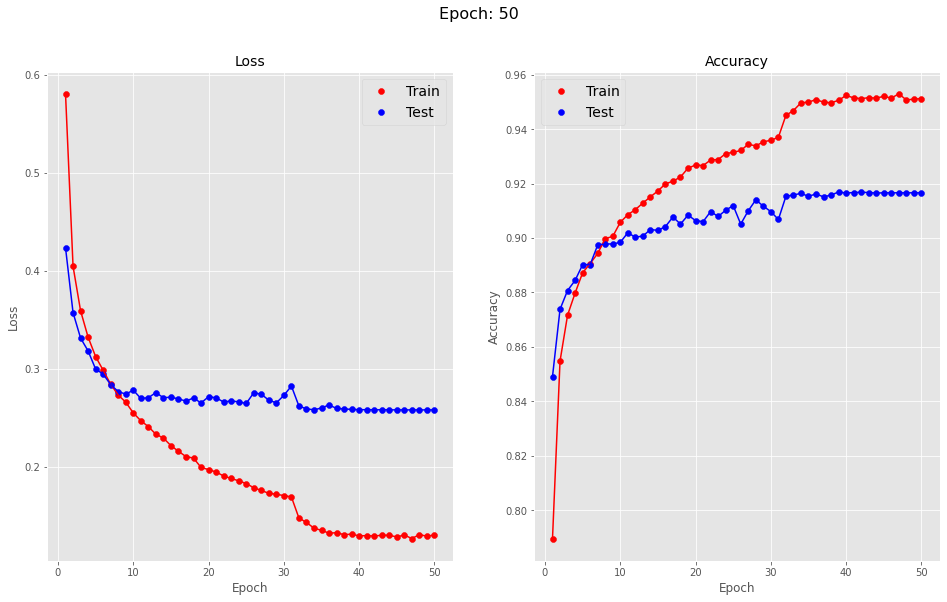

938/938 [==============================] - 5s 5ms/step - loss: 0.1307 - accuracy: 0.9512 - val_loss: 0.2582 - val_accuracy: 0.9166 - lr: 1.0000e-08


In [ ]:
from utils import create_model_checkpoint, reduce_lr, MonitorTraining

history = model.fit(train_dataset,
                    validation_data=test_dataset,
                    epochs=50,
                    callbacks=[reduce_lr(), MonitorTraining(), create_model_checkpoint(model.name) ])

### Results 

In [ ]:
model_best = tf.keras.models.load_model(f"models/{MODEL_NAME}")

_, train_acc = model_best.evaluate(train_images, train_labels)
_, test_acc = model_best.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.2588 - accuracy: 0.9169


In [ ]:
print(f"Train accuracy: {train_acc}")
print(f"Test accuracy: {test_acc}")

Train accuracy: 0.9737333059310913
Test accuracy: 0.9168999791145325


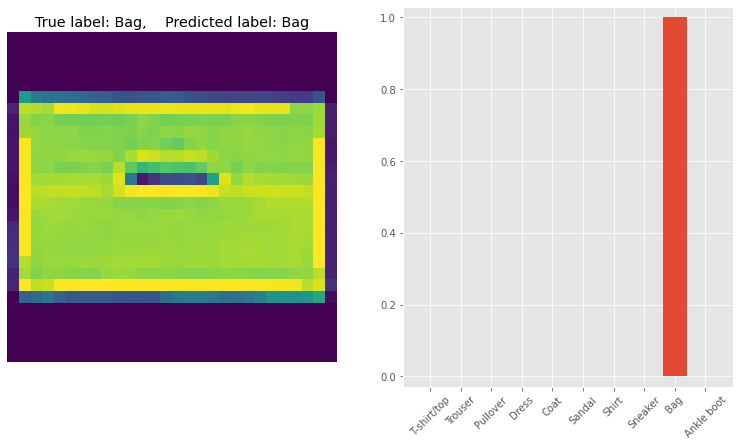

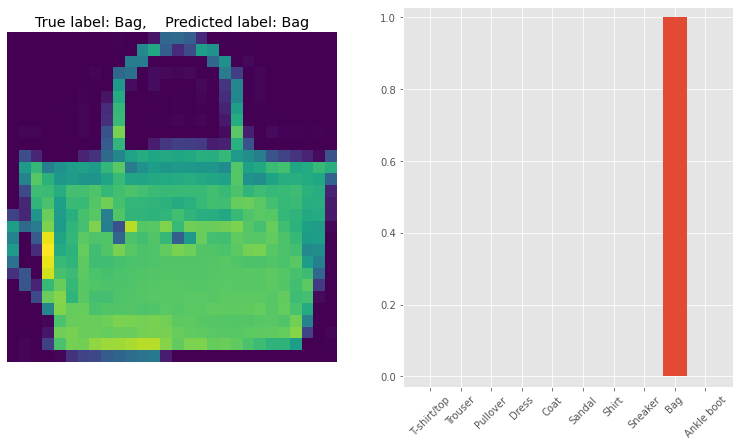

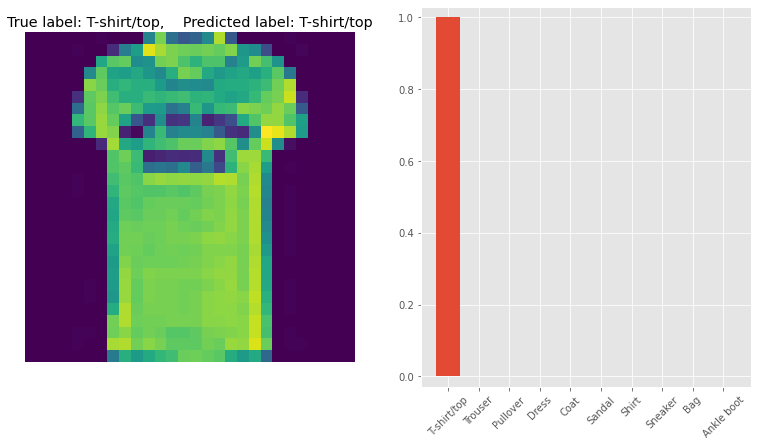

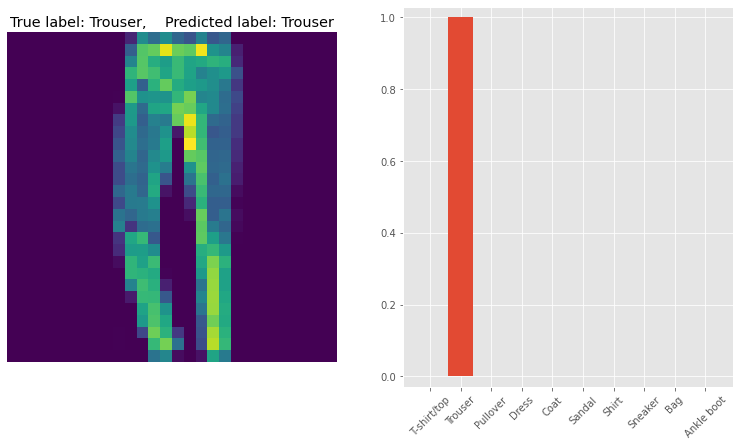

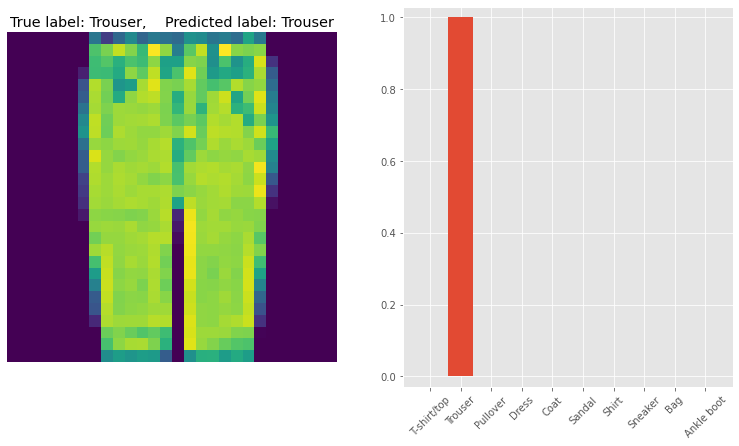

In [ ]:
import warnings
from utils import predict_class

warnings.filterwarnings("ignore")

for i in range(5):
  predict_class(model_best, test_images, test_labels, class_names)

In [ ]:
model_best.save(f'{MODEL_NAME}.h5')

## horses_or_humans

### Data preparation

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
(train_data, test_data), ds_info = tfds.load(name="horses_or_humans",
                                             split=["train", "test"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

ds_info

tfds.core.DatasetInfo(
    name='horses_or_humans',
    full_name='horses_or_humans/3.0.0',
    description="""
    A large set of images of horses and humans.
    """,
    homepage='http://laurencemoroney.com/horses-or-humans-dataset',
    data_path='~\\tensorflow_datasets\\horses_or_humans\\3.0.0',
    file_format=tfrecord,
    download_size=153.59 MiB,
    dataset_size=153.53 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=256, num_shards=1>,
        'train': <SplitInfo num_examples=1027, num_shards=2>,
    },
    citation="""@ONLINE {horses_or_humans,
    author = "Laurence Moroney",
    title = "Horses or Humans Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/horses-or-humans-dataset"
    }""",
)

In [ ]:
len(train_data), len(test_data)

(1027, 256)

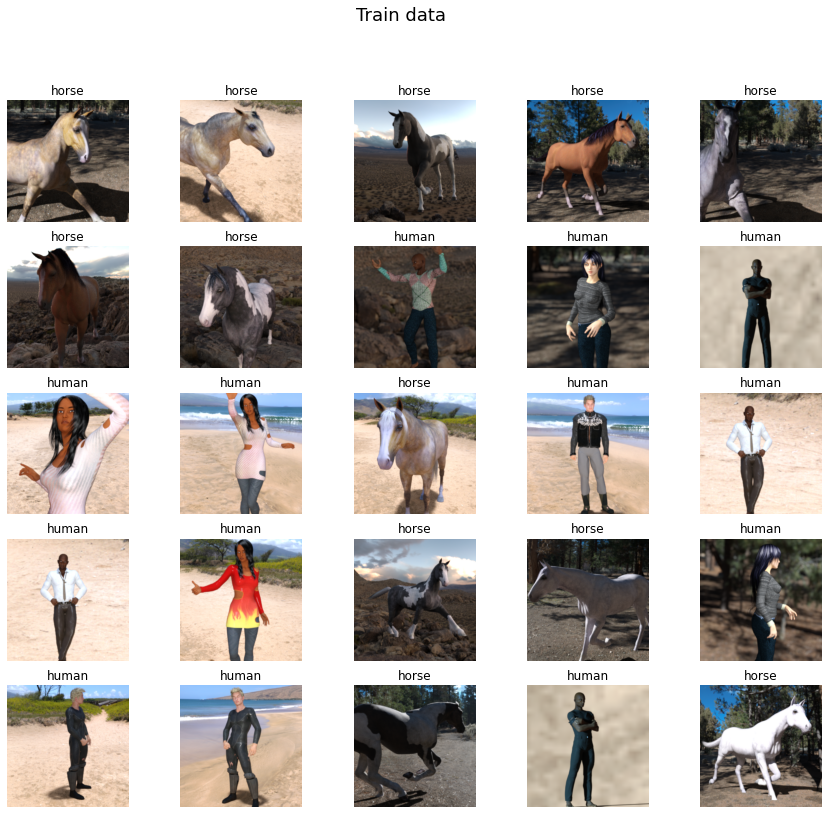

In [ ]:
import matplotlib.pyplot as plt

class_names = ["horse", "human"]

fig, axs = plt.subplots(5, 5, figsize=(15, 13))
fig.suptitle('Train data', fontsize=18)

for i, (image, label) in enumerate(train_data.take(25)):
  axs[i//5, i%5].imshow(image)
  axs[i//5, i%5].set_title(f"{class_names[label]}")
  axs[i//5, i%5].axis("off")

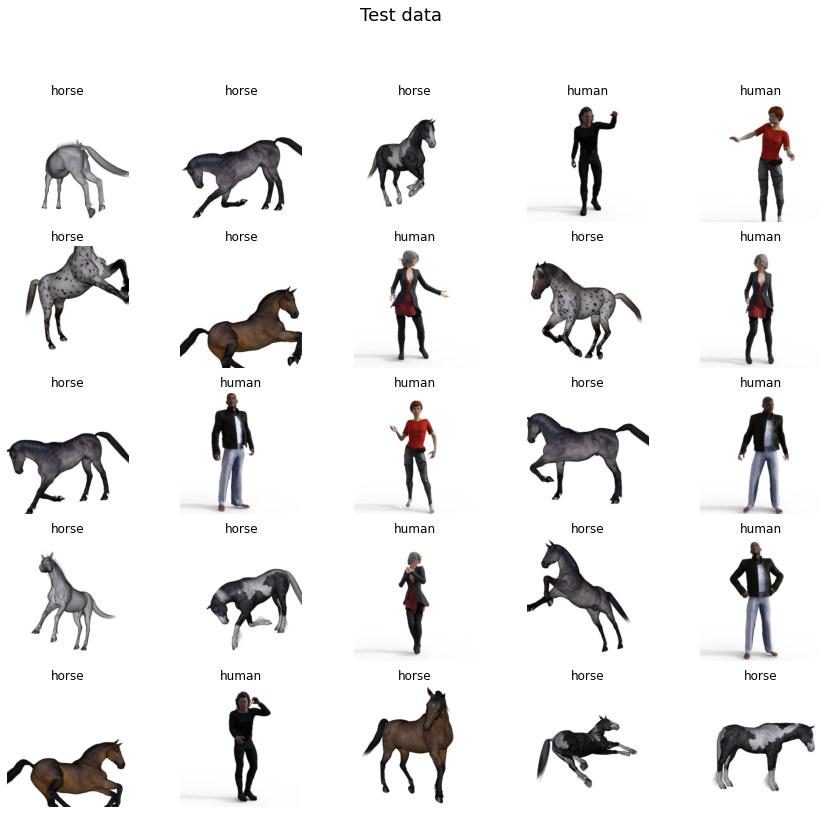

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(15, 13))
fig.suptitle('Test data', fontsize=18)

for i, (image, label) in enumerate(test_data.take(25)):
  axs[i//5, i%5].imshow(image)
  axs[i//5, i%5].set_title(f"{class_names[label]}")
  axs[i//5, i%5].axis("off")

In [ ]:
from tensorflow.keras.layers import Resizing, Rescaling, Lambda
from tensorflow.keras.models import Sequential

to_grayscale = Lambda(tf.image.rgb_to_grayscale)


preprocessing_layer = Sequential([to_grayscale,
                                  Resizing(120, 120),
                                  Rescaling(1/255.0)
                                  ], name="preprocessing_layer")

preprocess_img = lambda image, label: (preprocessing_layer(image), label)

train_data = train_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras import Sequential

data_augmentation = Sequential([RandomFlip("horizontal")])

In [ ]:
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

### Model & Training

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2

MODEL_NAME = "model_humans_and_horses"

model = Sequential([
                    data_augmentation,
                    Conv2D(16, (3, 3), activation='relu', input_shape=(120, 120, 1), kernel_regularizer=l2(1e-4)),
                    BatchNormalization(),
                    MaxPooling2D(2, 2),
                    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)),
                    BatchNormalization(),
                    MaxPooling2D(2, 2),
                    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)),
                    BatchNormalization(),
                    MaxPooling2D(2, 2),
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(128, activation='relu'),
                    Dense(1, activation="sigmoid")
], name=MODEL_NAME)

model.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [ ]:
!wget https://raw.githubusercontent.com/KornelWitkowski/TensorFlow-benchmarks/main/utils.py

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    if epoch < 20:
        lr = 1e-3
    elif epoch < 30:
        lr = 0.5e-3
    elif epoch < 40:
        lr = 1e-4
    elif epoch < 50:
        lr = 0.5e-4
    elif epoch < 60:
        lr = 1e-5
    else:
        lr = 0.5e-5
    print('Learning rate: ', lr)
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

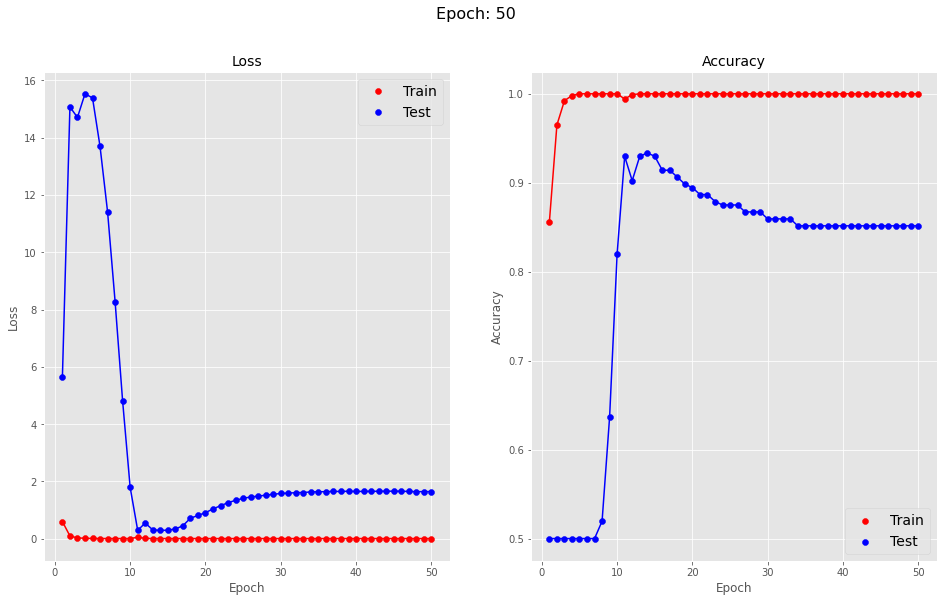

33/33 [==============================] - 11s 282ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 1.6463 - val_accuracy: 0.8516 - lr: 1.0000e-05


In [ ]:
from utils import MonitorTraining, create_model_checkpoint

history = model.fit(train_data,
                    epochs=50,
                    validation_data=test_data,
                    callbacks=[MonitorTraining(), lr_scheduler, create_model_checkpoint(model.name)])

### Results

In [ ]:
model_best = tf.keras.models.load_model(f"models/{MODEL_NAME}")

_, train_acc = model_best.evaluate(train_data)
_, test_acc = model_best.evaluate(test_data)

8/8 [==============================] - 0s 30ms/step - loss: 0.2903 - accuracy: 0.9336


In [ ]:
print(f"Train accuracy: {train_acc}")
print(f"Test accuracy: {test_acc}")

Train accuracy: 0.9513145089149475
Test accuracy: 0.93359375


## rock_paper_scissors

### Data preparation

In [ ]:
import tensorflow_datasets as tfds

(train_dataset, test_dataset), ds_info = tfds.load(name='rock_paper_scissors',
                                                   data_dir='tmp',
                                                   as_supervised=True,
                                                   with_info=True,
                                                   split=[tfds.Split.TRAIN, tfds.Split.TEST] )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2520 [00:00<?, ? examples/s]

Shuffling tmp/rock_paper_scissors/3.0.0.incompleteW4UK7V/rock_paper_scissors-train.tfrecord*...:   0%|        …

Generating test examples...:   0%|          | 0/372 [00:00<?, ? examples/s]

Shuffling tmp/rock_paper_scissors/3.0.0.incompleteW4UK7V/rock_paper_scissors-test.tfrecord*...:   0%|         …

Dataset rock_paper_scissors downloaded and prepared to tmp/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_path='tmp/rock_paper_scissors/3.0.0',
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
)

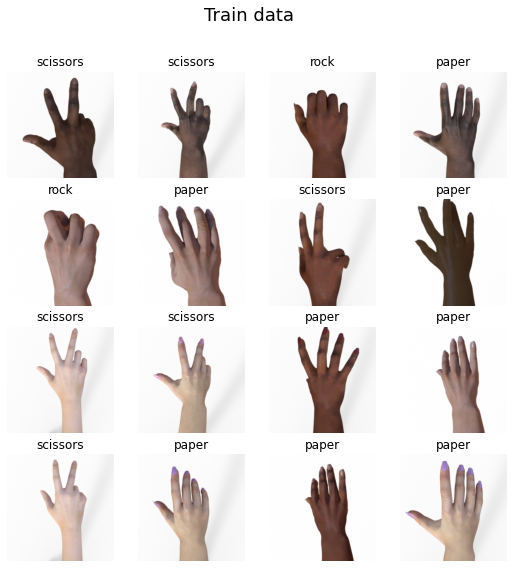

In [ ]:
from matplotlib import axes
import matplotlib.pyplot as plt

class_names = ["rock", "paper", "scissors"]

fig, axs = plt.subplots(4, 4, figsize=(9, 9))
fig.suptitle('Train data', fontsize=18)

for i, (image, label) in enumerate(train_dataset.take(16)):

  axs[i//4, i%4].imshow(image)
  axs[i//4, i%4].set_title(f"{class_names[label]}")
  axs[i//4, i%4].axis("off")

In [ ]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation
from tensorflow.keras import Sequential

data_augmentation = Sequential([RandomFlip("horizontal"),
                                RandomRotation(0.1),
                                RandomZoom(0.1),
                                RandomTranslation(0.1, 0.1)])

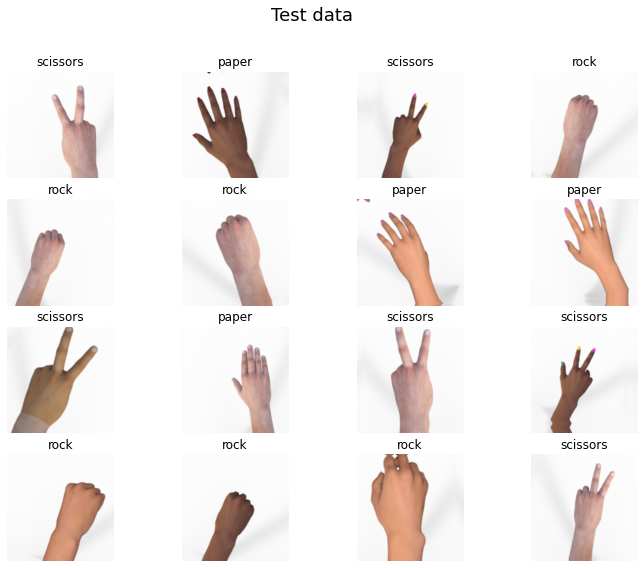

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(12, 9))
fig.suptitle('Test data', fontsize=18)

for i, (image, label) in enumerate(test_dataset.take(16)):
  aug_image = data_augmentation(image, training=True)
  axs[i//4, i%4].imshow(aug_image/255.0)
  axs[i//4, i%4].set_title(f"{class_names[label]}")
  axs[i//4, i%4].axis("off")

In [ ]:
from tensorflow.keras.layers import Resizing, Rescaling, Lambda

to_grayscale = tf.keras.layers.Lambda(tf.image.rgb_to_grayscale)


preprocessing_layer = Sequential([to_grayscale,
                                  Resizing(120, 120),
                                  Rescaling(1/255.0)
                                  ], name="preprocessing_layer")

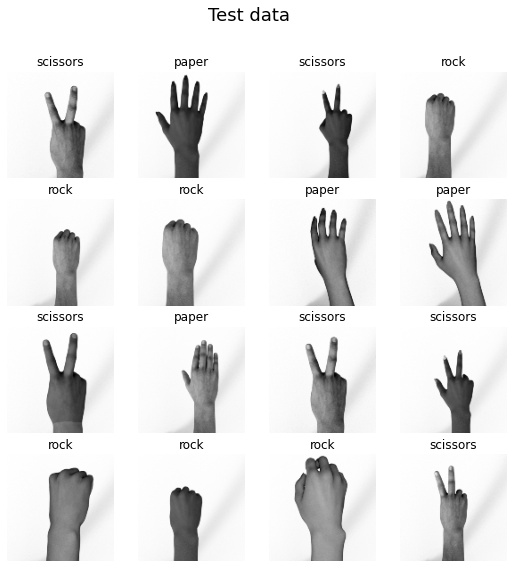

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
fig.suptitle('Test data', fontsize=18)

for i, (image, label) in enumerate(test_dataset.take(16)):

  axs[i//4, i%4].imshow(tf.squeeze(preprocessing_layer(image)), cmap='gray')
  axs[i//4, i%4].set_title(f"{class_names[label]}")
  axs[i//4, i%4].axis("off")

In [ ]:
import tensorflow as tf

preprocess_img = lambda image, label: (preprocessing_layer(image), label)

train_dataset = train_dataset.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_data = train_dataset.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### Model & Traning

In [ ]:
data_augmentation = Sequential([RandomFlip("horizontal"),
                                RandomRotation(0.1),
                                RandomZoom(0.1),
                                RandomTranslation(0.1, 0.1)])

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

MODEL_NAME = "model_rock_paper_scissors"

model = Sequential([  
                      data_augmentation,
                      Conv2D(filters=32, kernel_size=5, input_shape=(120, 120, 1), kernel_regularizer=l2(1e-4)),
                      BatchNormalization(),
                      MaxPooling2D(pool_size=2, strides=2),
                      Conv2D(filters=64, kernel_size=4, kernel_regularizer=l2(1e-4)),
                      BatchNormalization(), 
                      MaxPooling2D(pool_size=2, strides=2),
                      Conv2D(128, 3, activation="relu", kernel_regularizer=l2(1e-4)),
                      BatchNormalization(),
                      MaxPooling2D(pool_size=2),
                      Conv2D(128, 3, activation="relu", kernel_regularizer=l2(1e-4)),
                      BatchNormalization(),
                      MaxPooling2D(pool_size=2),
                      Flatten(),
                      Dense(256, activation="relu"),
                      Dense(3, activation="softmax")
], name=MODEL_NAME)

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=["accuracy"])

In [ ]:
!wget https://raw.githubusercontent.com/KornelWitkowski/TensorFlow-benchmarks/main/utils.py

--2022-08-23 22:40:12--  https://raw.githubusercontent.com/KornelWitkowski/TensorFlow-benchmarks/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3471 (3.4K) [text/plain]
Saving to: ‘utils.py.1’

utils.py.1          100%[===================>]   3.39K  --.-KB/s    in 0s      

2022-08-23 22:40:12 (64.2 MB/s) - ‘utils.py.1’ saved [3471/3471]



In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    if epoch < 10:
        lr = 1e-3
    elif epoch < 20:
        lr = 0.5e-3
    elif epoch < 30:
        lr = 1e-4
    elif epoch < 40:
        lr = 0.5e-4
    elif epoch < 50:
        lr = 1e-5
    else:
        lr = 0.5e-5
    print('Learning rate: ', lr)
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

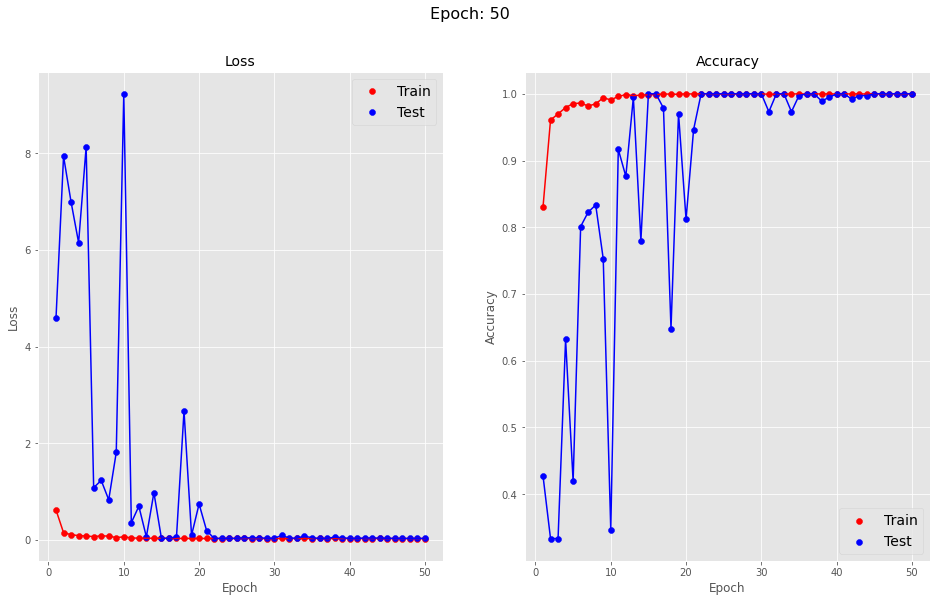

79/79 [==============================] - 4s 42ms/step - loss: 0.0260 - accuracy: 1.0000 - val_loss: 0.0284 - val_accuracy: 1.0000 - lr: 1.0000e-05


In [ ]:
from utils import create_model_checkpoint, MonitorTraining

history = model.fit(train_data,
                    epochs=50,
                    validation_data=test_data,
                    callbacks=[lr_scheduler, MonitorTraining(), create_model_checkpoint(model.name)])

### Results

In [ ]:
_, train_acc = model.evaluate(train_data, verbose=0)
_, test_acc = model.evaluate(test_data, verbose=0)

print(f"Train accuracy: {train_acc}")
print(f"Test accuracy: {test_acc}")

Train accuracy: 0.9980158805847168
Test accuracy: 1.0


In [ ]:
model_best.save(f'{model.name}.h5')

## MNIST

### Data preparation

In [1]:
import tensorflow_datasets as tfds

mnist_data, info = tfds.load("mnist",
                              shuffle_files=True,
                              with_info=True,
                              as_supervised=True)

mnist_train, mnist_test = mnist_data["train"], mnist_data["test"]

len(mnist_train), len(mnist_test)

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


(60000, 10000)

In [3]:
!wget https://raw.githubusercontent.com/KornelWitkowski/TensorFlow-benchmarks/main/utils.py

--2022-08-25 18:20:12--  https://raw.githubusercontent.com/KornelWitkowski/TensorFlow-benchmarks/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3471 (3.4K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   3.39K  --.-KB/s    in 0s      

2022-08-25 18:20:13 (38.3 MB/s) - ‘utils.py’ saved [3471/3471]



In [4]:
from utils import get_images_and_labels_from_dataset

train_images, train_labels = get_images_and_labels_from_dataset(mnist_train)
test_images, test_labels = get_images_and_labels_from_dataset(mnist_test)

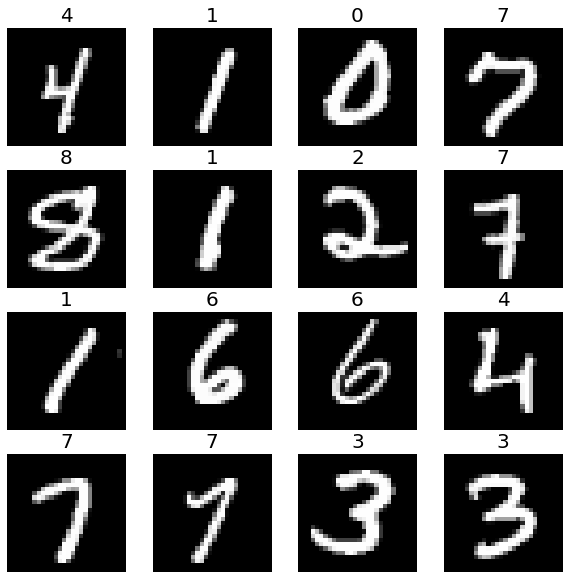

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

N = 4

fig, ax = plt.subplots(N, N, figsize=(10,10))

for i in range(N**2):
  image = train_images[i]
  label = train_labels[i]
  ax[i//N,i%N].imshow(tf.squeeze(image), cmap='gray')
  ax[i//N,i%N].axis(False)
  ax[i//N,i%N].set_title(str(label), fontsize=20)

### Autocoder

In [6]:
train_images = train_images/255.0
test_images = test_images/255.0

In [7]:
train_images_flatten = train_images.reshape(-1, 28*28)
test_images_flatten = test_images.reshape(-1, 28*28)

train_images.shape, test_images.shape, train_images_flatten.shape, test_images_flatten.shape

((60000, 28, 28, 1), (10000, 28, 28, 1), (60000, 784), (10000, 784))

In [8]:
train_images.max(), train_images.min(), test_images.max(), train_images.min()

(1.0, 0.0, 1.0, 0.0)

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_images_flatten))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_images_flatten))

train_dataset = train_dataset.batch(128).shuffle(1024).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(128).prefetch(tf.data.AUTOTUNE)

In [10]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Flatten, Rescaling, Conv2D
from tensorflow.keras.optimizers import Adam

MODEL_NAME = "autocoder"

autocoder = Sequential([Input(shape=(28, 28, 1)),
                    Conv2D(16, (4, 4), activation='relu'),
                    Flatten(),  
                    Dense(32, activation="relu"),    
                    Dense(28*28, activation="sigmoid")], name=MODEL_NAME)

autocoder.compile(loss="mse", optimizer=Adam())

In [11]:
autocoder.fit(train_dataset,
              epochs=10,
              validation_data=test_dataset)

Epoch 1/10
469/469 [==============================] - 15s 5ms/step - loss: 0.0422 - val_loss: 0.0209
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0188 - val_loss: 0.0168
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0167 - val_loss: 0.0156
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0158 - val_loss: 0.0150
Epoch 5/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0154 - val_loss: 0.0147
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0150 - val_loss: 0.0144
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0148 - val_loss: 0.0142
Epoch 8/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0144 - val_loss: 0.0138
Epoch 9/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0141 - val_loss: 0.0136
Epoch 10/10
469/469 [==============================] - 3s 7ms/step - loss: 0.0139 - val_loss: 0.013

In [12]:
autocoder.evaluate(test_dataset);

79/79 [==============================] - 0s 3ms/step - loss: 0.0134


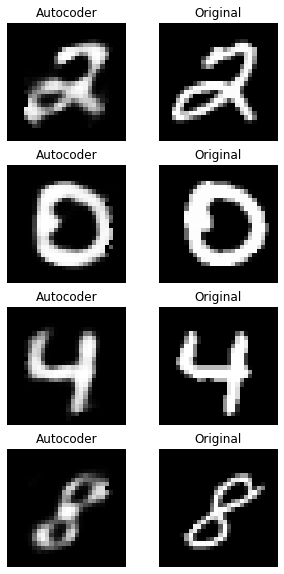

In [13]:
import matplotlib.pyplot as plt

autocoder_images = autocoder(test_images[:16,:,:,:], training=False).numpy()[0:16,:]

fig, ax = plt.subplots(4, 2, figsize=(5, 10))
for i in range(4):
  ax[i, 0].set_title("Autocoder")
  ax[i, 0].imshow(tf.squeeze(autocoder_images[i, :].reshape(28, 28)), cmap='gray')
  ax[i, 0].axis("off")
  ax[i, 1].set_title("Original")
  ax[i, 1].imshow(tf.squeeze(test_images[i, :, :, :]), cmap='gray')
  ax[i, 1].axis("off")

### Model & Traning

In [14]:
train_dataset = mnist_train.batch(128).shuffle(1024).prefetch(tf.data.AUTOTUNE)
test_dataset = mnist_test.batch(128).prefetch(tf.data.AUTOTUNE)

In [15]:
autocoder_layer = Sequential(autocoder.layers[:-1])

In [16]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Rescaling, Conv2D
from tensorflow.keras.optimizers import Adam

MODEL_NAME = "model_MNIST"

model = Sequential([Rescaling(1/255.0),
                    autocoder_layer,
                    Dense(64, activation="relu"),    
                    Dense(10, activation="softmax")], name=MODEL_NAME)

In [17]:
model.compile(loss="sparse_categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

In [18]:
from utils import reduce_lr, create_model_checkpoint

model.fit(train_dataset,
          epochs=30,
          validation_data=test_dataset,
          callbacks=[reduce_lr(), create_model_checkpoint(model.name)]
)

Epoch 1/30
469/469 [==============================] - 4s 8ms/step - loss: 1.0409 - accuracy: 0.8363 - val_loss: 0.1659 - val_accuracy: 0.9486 - lr: 0.0010
Epoch 2/30
469/469 [==============================] - 3s 6ms/step - loss: 0.1396 - accuracy: 0.9585 - val_loss: 0.1073 - val_accuracy: 0.9668 - lr: 0.0010
Epoch 3/30
469/469 [==============================] - 3s 5ms/step - loss: 0.0932 - accuracy: 0.9717 - val_loss: 0.0853 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 4/30
469/469 [==============================] - 3s 5ms/step - loss: 0.0709 - accuracy: 0.9790 - val_loss: 0.0668 - val_accuracy: 0.9782 - lr: 0.0010
Epoch 5/30
469/469 [==============================] - 2s 4ms/step - loss: 0.0561 - accuracy: 0.9831 - val_loss: 0.0698 - val_accuracy: 0.9774 - lr: 0.0010
Epoch 6/30
469/469 [==============================] - 3s 5ms/step - loss: 0.0451 - accuracy: 0.9862 - val_loss: 0.0595 - val_accuracy: 0.9810 - lr: 0.0010
Epoch 7/30
469/469 [==============================] - 3s 6ms/step - lo

### Results

In [19]:
model_best = tf.keras.models.load_model(f"models/{model.name}")

_, train_acc = model_best.evaluate(train_dataset)
_, test_acc = model_best.evaluate(test_dataset)

79/79 [==============================] - 0s 3ms/step - loss: 0.0673 - accuracy: 0.9872


In [ ]:
print(f"Train accuracy: {train_acc}")
print(f"Test accuracy: {test_acc}")

Train accuracy: 0.9998000264167786
Test accuracy: 0.9842000007629395


### The worst predictions

In [ ]:
import pandas as pd

predictions = model_best.predict(test_dataset)
predictions_labels = tf.argmax(predictions, axis=1)

MAE = tf.metrics.MAE(predictions, tf.one_hot(test_labels, 10))

MAE_df = pd.DataFrame(MAE, columns=["MAE"])
MAE_df_sorted = MAE_df.sort_values("MAE", ascending=False)

79/79 [==============================] - 0s 4ms/step


In [ ]:
worst_predictions_indices = MAE_df_sorted.index.to_list()[:25]

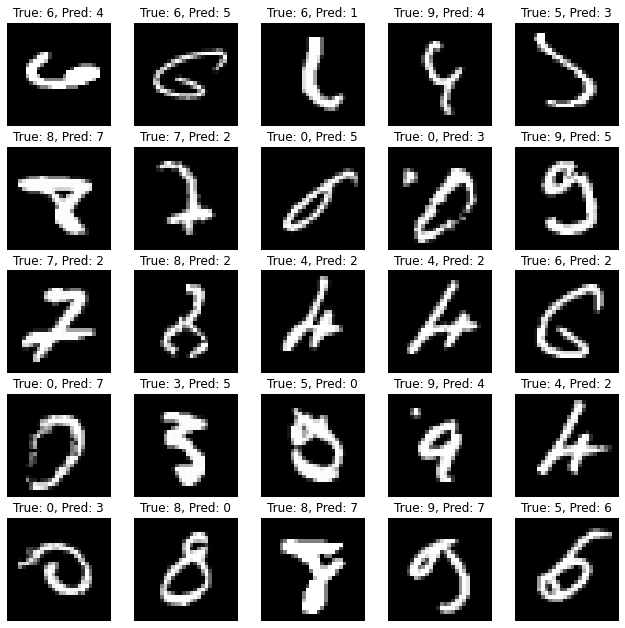

In [ ]:
fig, ax = plt.subplots(5,5, figsize=(11,11))

for i, j in enumerate(worst_predictions_indices):
  image = test_images[j]
  true_label = test_labels[j]
  pred_label = predictions_labels[j]
  ax[i//N,i%N].imshow(tf.squeeze(image), cmap='gray')
  ax[i//N,i%N].axis(False)
  ax[i//N,i%N].set_title(f"True: {true_label}, Pred: {pred_label}")

## tf_flowers

### Data preparation

In [ ]:
import tensorflow_datasets as tfds

(training_set, validation_set), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

In [ ]:
class_names = ds_info.features['label'].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [ ]:
for i, (image, label) in enumerate(training_set.take(5)):
    print(f"Image {i} shape: {image.shape}, min: {tf.reduce_min(image).numpy()} max: {tf.reduce_max(image).numpy()}     label: {class_names[label]}")

Image 0 shape: (333, 500, 3), min: 0 max: 255     label: tulips
Image 1 shape: (212, 320, 3), min: 0 max: 255     label: sunflowers
Image 2 shape: (240, 320, 3), min: 0 max: 255     label: sunflowers
Image 3 shape: (240, 320, 3), min: 0 max: 255     label: roses
Image 4 shape: (317, 500, 3), min: 0 max: 255     label: sunflowers


In [ ]:
from tensorflow.keras.layers import Rescaling, Resizing
from tensorflow.keras import Sequential

preprocessing_layer = Sequential([Resizing(200, 200),
                                  Rescaling(1/255.0)
                                  ], name="preprocessing_layer")

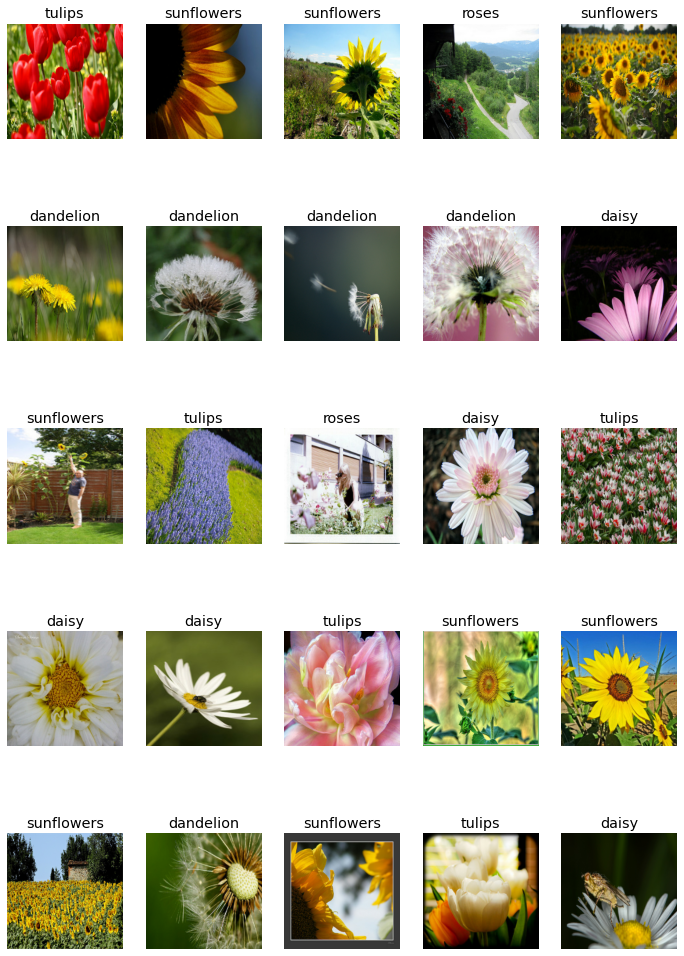

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 5, figsize=(12, 18))

for i, (image, label) in enumerate(training_set.take(25)):
    image = tf.cast(preprocessing_layer(image), tf.float32)
    axs[i//5, i%5].imshow(image)
    axs[i//5, i%5].axis("off")
    axs[i//5, i%5].set_title(class_names[label])

In [ ]:
import tensorflow as tf

preprocess_img = lambda image, label: (preprocessing_layer(image), label)

train_data = training_set.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = validation_set.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=20,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator()

In [ ]:
!wget https://raw.githubusercontent.com/KornelWitkowski/TensorFlow-benchmarks/main/utils.py

--2022-08-10 21:59:51--  https://raw.githubusercontent.com/KornelWitkowski/TensorFlow-benchmarks/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3471 (3.4K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   3.39K  --.-KB/s    in 0s      

2022-08-10 21:59:51 (46.9 MB/s) - ‘utils.py’ saved [3471/3471]



In [ ]:
from utils import get_images_and_labels_from_dataset

train_images, train_labels = get_images_and_labels_from_dataset(train_data)
test_images, test_labels = get_images_and_labels_from_dataset(test_data)

In [ ]:
train_data = train_datagen.flow(train_images,
                                train_labels,
                                batch_size=16,
                                shuffle=True)

test_data = test_datagen.flow(test_images,
                              test_labels,
                              batch_size=16)

In [ ]:
augmented_images, augmented_labels = train_data.next()

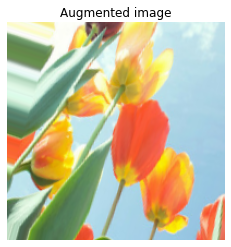

In [ ]:
import random
import matplotlib.pyplot as plt

random_number = random.randint(0, 16)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

### Model & Traning

In [ ]:
!wget https://raw.githubusercontent.com/KornelWitkowski/TensorFlow-benchmarks/main/resnet.py

--2022-08-10 22:09:55--  https://raw.githubusercontent.com/KornelWitkowski/TensorFlow-benchmarks/main/resnet.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4071 (4.0K) [text/plain]
Saving to: ‘resnet.py’

resnet.py           100%[===================>]   3.98K  --.-KB/s    in 0s      

2022-08-10 22:09:56 (46.8 MB/s) - ‘resnet.py’ saved [4071/4071]



In [ ]:
from resnet import resnet_v2

model = resnet_v2(input_shape = (200, 200, 3), depth = 56, num_classes=5)

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=["accuracy"], name="tf_flowers")

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")
mixed_precision.global_policy()

<Policy "mixed_float16">

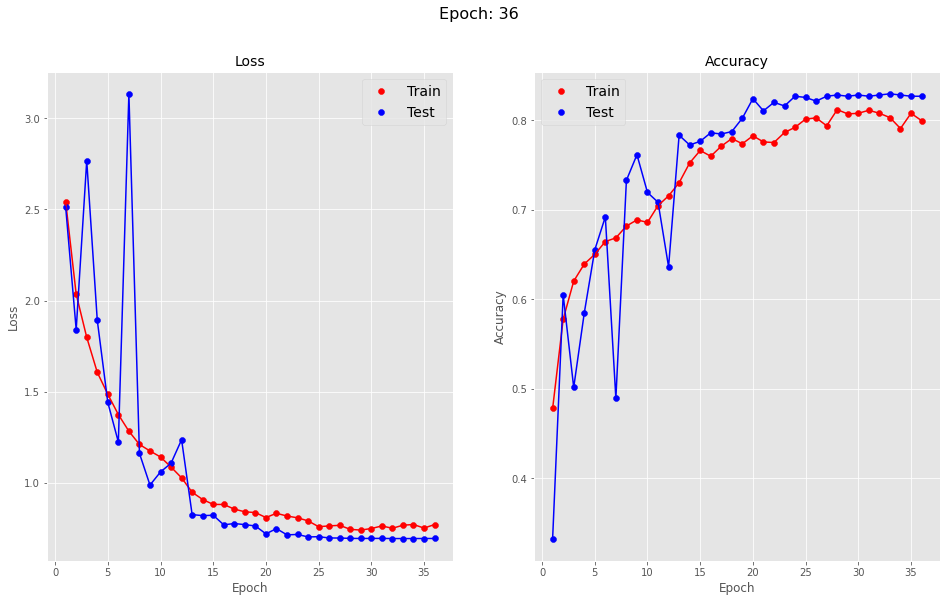


Epoch 36: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
184/184 [==============================] - 100s 545ms/step - loss: 0.7694 - accuracy: 0.7997 - val_loss: 0.6928 - val_accuracy: 0.8270 - lr: 1.0000e-07
Epoch 37/100
 73/184 [==========>...................] - ETA: 57s - loss: 0.7520 - accuracy: 0.8031

KeyboardInterrupt: ignored

In [ ]:
from utils import create_model_checkpoint, MonitorTraining, reduce_lr

history = model.fit(train_data,
                    epochs=100,
                    validation_data=test_data,
                    callbacks=[MonitorTraining(), reduce_lr(), create_model_checkpoint(model.name)])

### Results

In [ ]:
train_datagen = ImageDataGenerator()

train_data = train_datagen.flow(train_images,
                                train_labels,
                                batch_size=16) # not augmented

In [ ]:
model_best = tf.keras.models.load_model(f"models/tf_flowers")

_, train_acc = model_best.evaluate(train_data)
_, test_acc = model_best.evaluate(test_data)

46/46 [==============================] - 6s 131ms/step - loss: 0.6924 - accuracy: 0.8297


In [ ]:
print(f"Train accuracy: {train_acc}")
print(f"Test accuracy: {test_acc}")

Train accuracy: 0.847752034664154
Test accuracy: 0.8297002911567688


In [ ]:
model_best.save('model_tf_flowers.h5')

## food101

### Data exploration

In [ ]:
import tensorflow_datasets as tfds

(train_data, test_data), ds_info = tfds.load(name="food101", 
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)


  Image shape: (384, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Image min value: 0
  Image max value: 255
  Target class from Food101 (tensor form): 56
  Class name: huevos_rancheros
        


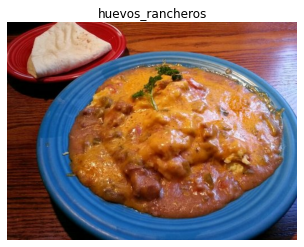


  Image shape: (512, 384, 3)
  Image dtype: <dtype: 'uint8'>
  Image min value: 0
  Image max value: 255
  Target class from Food101 (tensor form): 55
  Class name: hot_dog
        


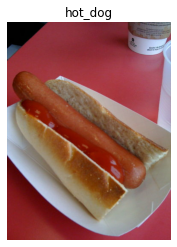


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Image min value: 0
  Image max value: 255
  Target class from Food101 (tensor form): 72
  Class name: pancakes
        


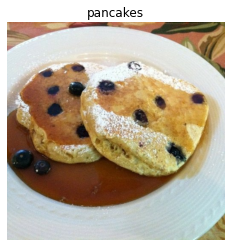


  Image shape: (382, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Image min value: 0
  Image max value: 255
  Target class from Food101 (tensor form): 68
  Class name: onion_rings
        


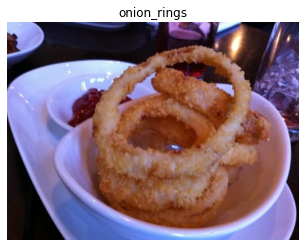


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Image min value: 0
  Image max value: 255
  Target class from Food101 (tensor form): 16
  Class name: cheesecake
        


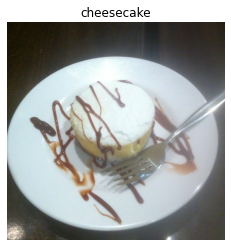

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

class_names = ds_info.features["label"].names

for image, label in train_data.take(5):
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Image min value: {tf.reduce_min(image)}
  Image max value: {tf.reduce_max(image)}
  Target class from Food101 (tensor form): {label}
  Class name: {class_names[label.numpy()]}
        """)
  
  plt.imshow(image)
  plt.axis("off")
  plt.title(class_names[int(label)])
  plt.show()

### Preprocessing

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Resizing, Rescaling

preprocessing_layer = Sequential([Resizing(180, 180),
                                  Rescaling(1/255.0)
                                  ], name="preprocessing_layer")

In [ ]:
BATCH_SIZE = 16

preprocess_img = lambda image, label: (preprocessing_layer(image), label)

train_data = train_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.batch(16).prefetch(tf.data.AUTOTUNE)

train_data_rpt = train_data.repeat()
test_data_rpt = test_data.repeat()

### Model

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
!wget https://raw.githubusercontent.com/KornelWitkowski/TensorFlow-benchmarks/main/resnet.py
!wget https://raw.githubusercontent.com/KornelWitkowski/TensorFlow-benchmarks/main/utils.py

--2022-08-15 13:19:34--  https://raw.githubusercontent.com/KornelWitkowski/TensorFlow-benchmarks/main/resnet.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4071 (4.0K) [text/plain]
Saving to: ‘resnet.py.1’

resnet.py.1         100%[===================>]   3.98K  --.-KB/s    in 0s      

2022-08-15 13:19:35 (72.5 MB/s) - ‘resnet.py.1’ saved [4071/4071]

--2022-08-15 13:19:35--  https://raw.githubusercontent.com/KornelWitkowski/TensorFlow-benchmarks/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3471 (3.4K) [text/

In [ ]:
MODEL_NAME = "model_food101"

In [ ]:
from resnet import resnet_v2

model = resnet_v2(input_shape = (180, 180, 3), depth = 110, num_classes=101)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule(0)),
              metrics=["accuracy"])

Learning rate:  0.001


### Training: stage 1

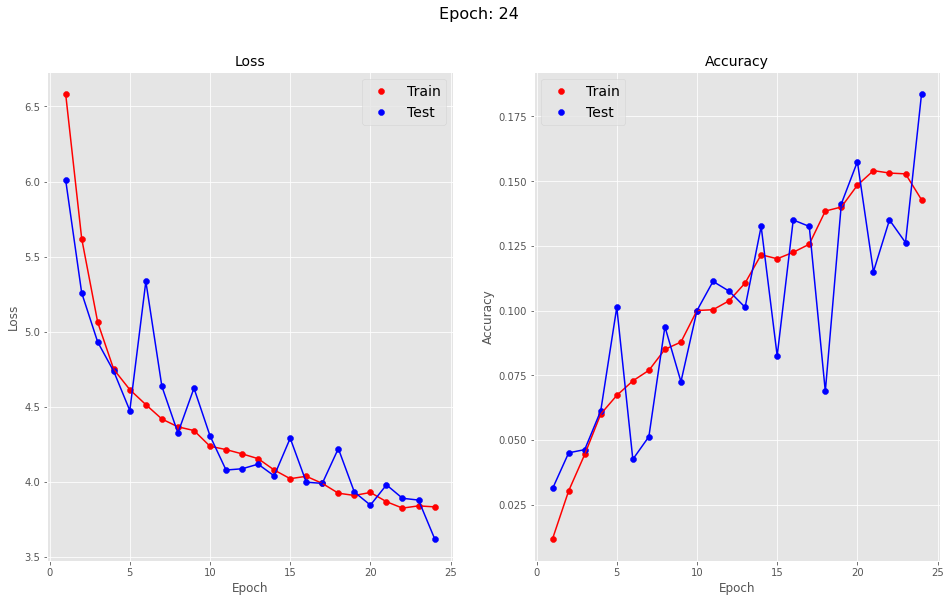

200/200 [==============================] - 184s 920ms/step - loss: 3.8334 - accuracy: 0.1428 - val_loss: 3.6225 - val_accuracy: 0.1838 - lr: 0.0010


In [ ]:
from utils import create_model_checkpoint, MonitorTraining, reduce_lr

history = model.fit(train_data,
                    epochs=24,
                    steps_per_epoch=200,
                    validation_data=test_data,
                    validation_steps=50,
                    callbacks=[MonitorTraining(), lr_scheduler, create_model_checkpoint(MODEL_NAME)])

In [ ]:
model_best = tf.keras.models.load_model(f"models/{MODEL_NAME}")

_, train_acc = model_best.evaluate(train_data, verbose=0)
_, test_acc = model_best.evaluate(test_datal, verbose=0)

In [ ]:
print(f"Train accuracy: {train_acc}")
print(f"Test accuracy: {test_acc}")

Train accuracy: 0.18308910727500916
Test accuracy: 0.1810692995786667


In [ ]:
model_best.save(f'{MODEL_NAME}.h5')

### Traning: stage 3

In [ ]:
model = tf.keras.models.load_model(f"models/{MODEL_NAME}")

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    lr = 0.5e-3
    if epoch >= 80:
        lr = 0.5e-5
    elif epoch >= 60:
        lr = 1e-5
    elif epoch >= 40:
        lr = 0.5 * 1e-4
    elif epoch >= 20:
        lr = 1e-4
    print('Learning rate: ', lr)
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

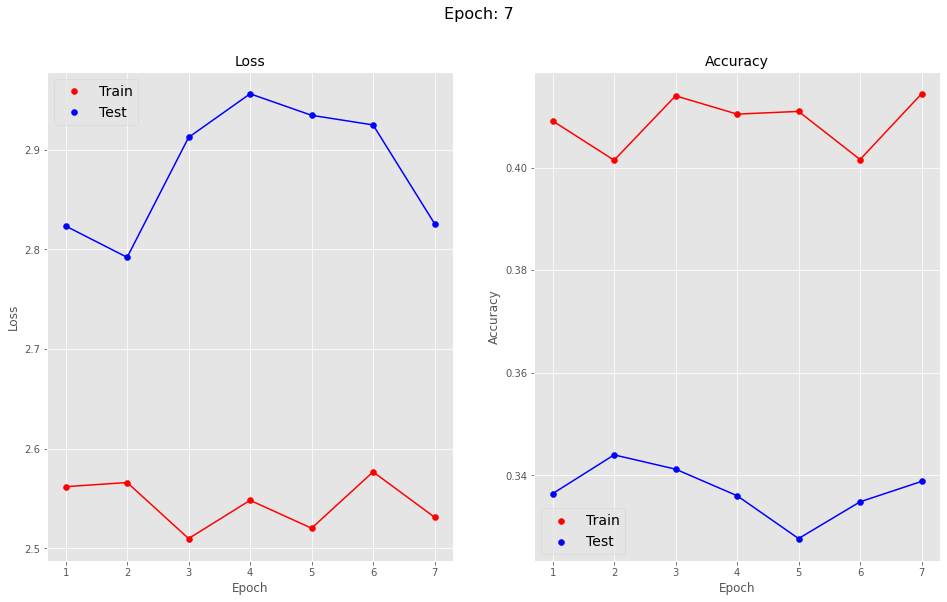

473/473 [==============================] - 498s 1s/step - loss: 2.5310 - accuracy: 0.4144 - val_loss: 2.8258 - val_accuracy: 0.3388 - lr: 5.0000e-04
Learning rate:  0.0005
Epoch 8/100
 22/473 [>.............................] - ETA: 7:12 - loss: 2.4411 - accuracy: 0.4375

KeyboardInterrupt: ignored

In [ ]:
from utils import create_model_checkpoint, MonitorTraining, reduce_lr

history = model.fit(train_data_rpt,
                    epochs=100,
                    steps_per_epoch=len(train_data)//10,
                    validation_data=test_data_rpt,
                    validation_steps=len(test_data)//10,
                    callbacks=[MonitorTraining(), lr_scheduler, create_model_checkpoint(MODEL_NAME)])

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    lr = 1e-5
    if epoch >= 40:
        lr = 1e-7
    elif epoch >= 30:
        lr = 0.5 * 1e-6
    elif epoch >= 20:
        lr = 1e-6
    elif epoch >= 10:
        lr = 0.5 * 1e-5
    print('Learning rate: ', lr)
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

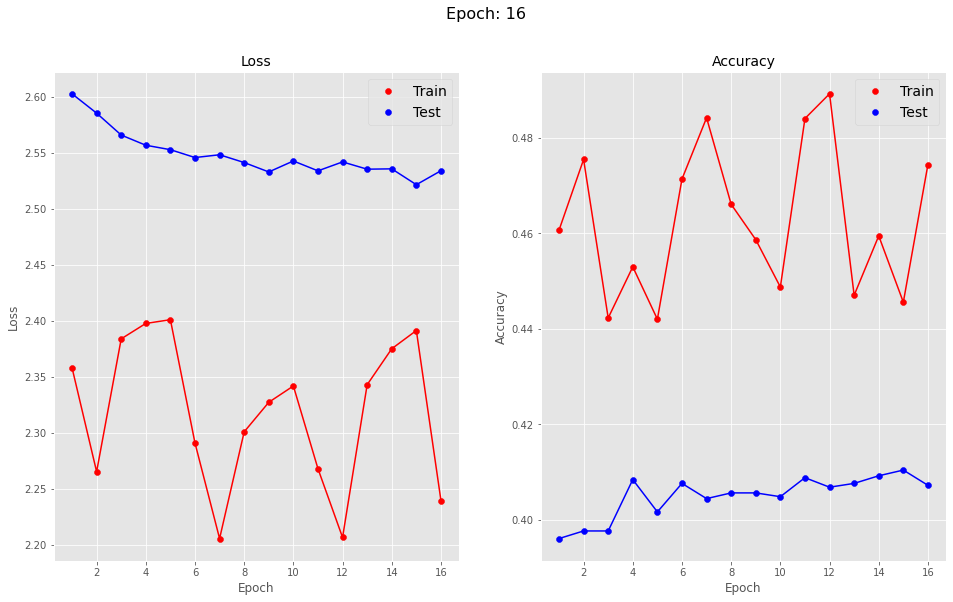

473/473 [==============================] - 499s 1s/step - loss: 2.2397 - accuracy: 0.4744 - val_loss: 2.5340 - val_accuracy: 0.4072 - lr: 5.0000e-06
Learning rate:  5e-06
Epoch 17/100
169/473 [=========>....................] - ETA: 4:50 - loss: 2.2261 - accuracy: 0.4830

In [ ]:
from utils import create_model_checkpoint, MonitorTraining, reduce_lr

history = model.fit(train_data_rpt,
                    epochs=100,
                    steps_per_epoch=len(train_data)//10,
                    validation_data=test_data_rpt,
                    validation_steps=len(test_data)//10,
                    callbacks=[MonitorTraining(), lr_scheduler, create_model_checkpoint(MODEL_NAME)])